# Gender prediction on USA baby names

* Download USA SSN data for top 100 baby names by gender per state from: https://www.ssa.gov/oact/babynames/limits.html
* Specifically download the file, which has all the names data: https://www.ssa.gov/oact/babynames/state/namesbystate.zip

    ```
    mkdir data
    wget https://www.ssa.gov/oact/babynames/state/namesbystate.zip
    mkdir SSN_data
    cd SSN_data
    unzip ../namesbystate.zip
    cd ..
    cat SSN_data/*.TXT > data/SSN_names_state.txt
    ```

* Download average state latitude and longitude from: http://dev.maxmind.com/geoip/legacy/codes/state_latlon/
* File name: https://dev.maxmind.com/static/csv/codes/state_latlon.csv



In [327]:
%matplotlib inline

import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn import cross_validation
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import TransformerMixin
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, LabelBinarizer

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("ticks")
sns.set_context("poster")

In [4]:
df = pd.read_csv("data/SSN_names_state.txt", header=None)

In [5]:
df.head()

,0,1,2,3,4
0,AK,F,1910,Mary,14
1,AK,F,1910,Annie,12
2,AK,F,1910,Anna,10
3,AK,F,1910,Margaret,8
4,AK,F,1910,Helen,7


In [6]:
df.columns = ["State", "Gender", "Year", "Name", "Count"]

In [7]:
df.head()

,State,Gender,Year,Name,Count
0,AK,F,1910,Mary,14
1,AK,F,1910,Annie,12
2,AK,F,1910,Anna,10
3,AK,F,1910,Margaret,8
4,AK,F,1910,Helen,7


In [8]:
df.shape

(5647426, 5)

In [12]:
df["Gender"].value_counts() # Instances per gender

F    3154009
M    2493417
dtype: int64

In [16]:
# Calculate number of names of each gender per year
df_t = df.pivot_table(values="Count", index="Year", columns="Gender", aggfunc=np.sum)
df_t.sum(axis=0)

Gender
F    143770075
M    155113251
dtype: int64

In [18]:
# Percentage of names of each gender per year
df_t.div(df_t.sum(axis=1), axis=0)*100

Gender,F,M
Year,,
1910,68.192277,31.807723
1911,65.812022,34.187978
1912,56.789649,43.210351
1913,55.121126,44.878874
1914,53.883410,46.116590
1915,53.759241,46.240759
1916,54.070282,45.929718
1917,53.911255,46.088745
1918,53.305410,46.694590


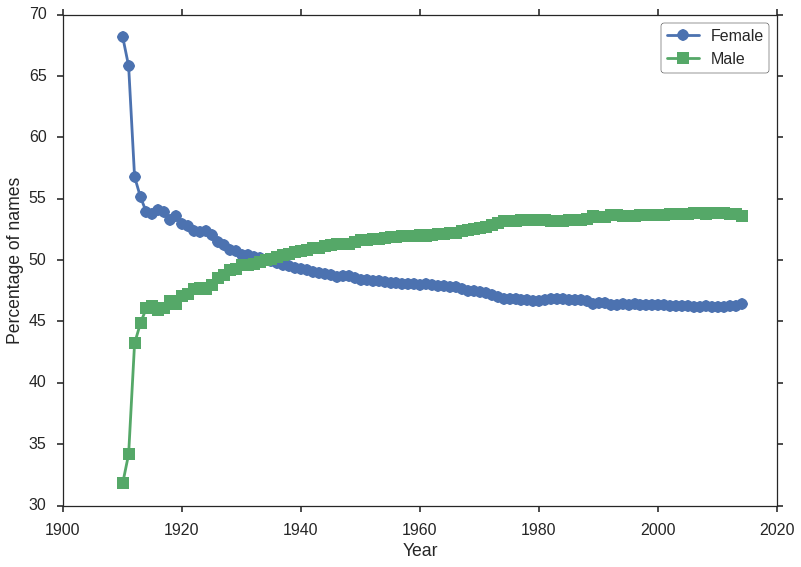

In [21]:
df_a = df_t.div(df_t.sum(axis=1), axis=0)*100
plt.plot(df_a.index, df_a["F"], label="Female", marker="o")
plt.plot(df_a.index, df_a["M"], label="Male", marker="s")
plt.xlabel("Year")
plt.ylabel("Percentage of names")
plt.legend(frameon=True, fancybox=True)

In [34]:
# Get top gender names per state
df.sort(["Count"], ascending=False).groupby(["State", "Gender"]).head(1)\
.pivot_table(values=["Name", "Count", "Year"], columns="Gender", index="State", aggfunc=lambda x: x.iloc[0])\
.swaplevel(0, 1, axis=1).sort_index(axis=1)

Gender     F                      M                   
       Count      Name  Year  Count         Name  Year
State                                                 
AK       164   Jessica  1985    207      Michael  1982
AL      2694      Mary  1925   3038        James  1947
AR      1424     Linda  1948   1620        James  1947
AZ       875   Jessica  1987   1045      Michael  1984
CA      6949   Jessica  1991   8268      Michael  1956
CO      1036     Linda  1948    973      Michael  1970
CT      1155     Linda  1947   1622       Robert  1947
DC       615     Linda  1949    884         John  1947
DE       207  Jennifer  1974    311      Michael  1958
FL      2739   Jessica  1987   3491      Michael  1990
GA      2614      Mary  1922   3066        James  1947
HI       243  Jennifer  1981    325      Michael  1957
IA      2365     Linda  1947   1667       Robert  1924
ID       530     Linda  1947    348      Michael  1954
IL      5285     Linda  1947   6220      Michael  1957
IN      3012     Linda  1947   2781      Michael  1954
KS      1387     Linda  1947   1184      Michael  1954
KY      2537      Mary  1924   2553        James  1947
LA      1648     Linda  1947   1667      Michael  1958
MA      3035      Mary  1921   3895       Robert  1947
MD      1505     Linda  1947   1789      Michael  1957
ME       778     Linda  1947    649       Robert  1947
MI      4538     Linda  1947   4924      Michael  1957
MN      2144     Linda  1948   2043        David  1955
MO      2797     Linda  1947   2430        James  1947
MS      1840      Mary  1927   2278        James  1947
MT       472     Linda  1948    403         John  1947
NC      3126      Mary  1924   3884        James  1947
ND       496     Linda  1947    344        David  1952
NE      1055     Linda  1947    937       Robert  1924
NH       437     Linda  1947    447       Robert  1947
NJ      2398  Jennifer  1972   3699         John  1964
NM       589      Mary  1947    543        David  1961
NV       268   Jessica  1988    341      Michael  1990
NY      7542     Linda  1947  10023       Robert  1947
OH      5881     Linda  1947   5492        David  1955
OK      2064     Linda  1947   1273        James  1925
OR      1121     Linda  1947    984      Michael  1953
PA      8184      Mary  1918   8048         John  1947
RI       485      Mary  1921    682       Robert  1947
SC      1742      Mary  1924   2314        James  1947
SD       507     Linda  1948    413       Robert  1925
TN      2785     Linda  1947   3279        James  1947
TX      5060     Linda  1947   4983  Christopher  1985
UT       702  Jennifer  1972    657      Michael  1980
VA      2307     Linda  1948   2676        James  1947
VT       325     Linda  1947    262        David  1955
WA      1751     Linda  1948   1620      Michael  1954
WI      2399      Mary  1954   2400        David  1955
WV      1795     Linda  1947   1682        James  1947
WY       229     Linda  1948    194        David  1955

In [38]:
# Get top gender names per state
# Same as above but more efficient syntax
df.sort(["Count"], ascending=False).groupby(["State", "Gender"]).head(1)\
.pivot(index="State", columns="Gender").swaplevel(0, 1, axis=1).sort_index(axis=1)

Gender     F                      M                   
       Count      Name  Year  Count         Name  Year
State                                                 
AK       164   Jessica  1985    207      Michael  1982
AL      2694      Mary  1925   3038        James  1947
AR      1424     Linda  1948   1620        James  1947
AZ       875   Jessica  1987   1045      Michael  1984
CA      6949   Jessica  1991   8268      Michael  1956
CO      1036     Linda  1948    973      Michael  1970
CT      1155     Linda  1947   1622       Robert  1947
DC       615     Linda  1949    884         John  1947
DE       207  Jennifer  1974    311      Michael  1958
FL      2739   Jessica  1987   3491      Michael  1990
GA      2614      Mary  1922   3066        James  1947
HI       243  Jennifer  1981    325      Michael  1957
IA      2365     Linda  1947   1667       Robert  1924
ID       530     Linda  1947    348      Michael  1954
IL      5285     Linda  1947   6220      Michael  1957
IN      3012     Linda  1947   2781      Michael  1954
KS      1387     Linda  1947   1184      Michael  1954
KY      2537      Mary  1924   2553        James  1947
LA      1648     Linda  1947   1667      Michael  1958
MA      3035      Mary  1921   3895       Robert  1947
MD      1505     Linda  1947   1789      Michael  1957
ME       778     Linda  1947    649       Robert  1947
MI      4538     Linda  1947   4924      Michael  1957
MN      2144     Linda  1948   2043        David  1955
MO      2797     Linda  1947   2430        James  1947
MS      1840      Mary  1927   2278        James  1947
MT       472     Linda  1948    403         John  1947
NC      3126      Mary  1924   3884        James  1947
ND       496     Linda  1947    344        David  1952
NE      1055     Linda  1947    937       Robert  1924
NH       437     Linda  1947    447       Robert  1947
NJ      2398  Jennifer  1972   3699         John  1964
NM       589      Mary  1947    543        David  1961
NV       268   Jessica  1988    341      Michael  1990
NY      7542     Linda  1947  10023       Robert  1947
OH      5881     Linda  1947   5492        David  1955
OK      2064     Linda  1947   1273        James  1925
OR      1121     Linda  1947    984      Michael  1953
PA      8184      Mary  1918   8048         John  1947
RI       485      Mary  1921    682       Robert  1947
SC      1742      Mary  1924   2314        James  1947
SD       507     Linda  1948    413       Robert  1925
TN      2785     Linda  1947   3279        James  1947
TX      5060     Linda  1947   4983  Christopher  1985
UT       702  Jennifer  1972    657      Michael  1980
VA      2307     Linda  1948   2676        James  1947
VT       325     Linda  1947    262        David  1955
WA      1751     Linda  1948   1620      Michael  1954
WI      2399      Mary  1954   2400        David  1955
WV      1795     Linda  1947   1682        James  1947
WY       229     Linda  1948    194        David  1955

In [39]:
df.head()

,State,Gender,Year,Name,Count
0,AK,F,1910,Mary,14
1,AK,F,1910,Annie,12
2,AK,F,1910,Anna,10
3,AK,F,1910,Margaret,8
4,AK,F,1910,Helen,7


In [49]:
# Take a random sample for testing
df_s = df.sample(2000)

In [50]:
df_s.head()

,State,Gender,Year,Name,Count
2053779,KY,M,1996,Anthony,160
2001265,KY,F,1996,Anastasia,6
5037902,TX,M,1998,Jovanny,14
3448730,NJ,M,1986,Darryl,39
1236903,GA,F,2007,Josie,36


In [57]:
# Group by name, state, year and find total per Gender per
df_s.pivot_table(index=["Name", "State", "Year"], columns="Gender")["Count"].reset_index().fillna(0)

Gender,Name,State,Year,F,M
0,Aarav,IL,2012,0,27
1,Aarion,IL,2004,0,6
2,Aaron,AZ,1951,0,5
3,Abagail,CA,2006,21,0
4,Abby,IL,2011,30,0
5,Abby,LA,1965,6,0
6,Abigayle,CA,2012,16,0
7,Abram,TX,2003,0,42
8,Adalee,FL,2010,6,0
9,Adam,AR,1967,0,13


In [58]:
# Do for full data:
df_props = df.pivot_table(index=["Name", "State", "Year"], columns="Gender")["Count"].reset_index().fillna(0)

In [60]:
df_props.head()

Gender,Name,State,Year,F,M
0,Aaban,NY,2013,0,6
1,Aaban,NY,2014,0,6
2,Aadan,CA,2008,0,7
3,Aadan,CA,2009,0,6
4,Aadan,CA,2014,0,5


In [64]:
df_props.columns

Index([u'Name', u'State', u'Year', u'F', u'M'], dtype='object', name=u'Gender')

In [66]:
df_props.shape, df.shape

((5448518, 5), (5647426, 5))

In [77]:
# Get top 20 names which have occured in the maximum number of years
df.groupby("Name")["Year"].apply(lambda x: len(x.unique())).sort(ascending=False, inplace=False).head(20)

Name
Antoinette    105
Nellie        105
Dolores       105
Ivory         105
Ivy           105
Dixie         105
Nina          105
Amos          105
Jack          105
Jackie        105
Jackson       105
Nick          105
Jacob         105
Nicholas      105
Jacqueline    105
Nelson        105
Neil          105
Grant         105
Neal          105
Nathaniel     105
Name: Year, dtype: int64

In [104]:
df_props["Total"] = df_props[["F", "M"]].sum(axis=1)
df_props["MaxCount"] = df_props[["F", "M"]].max(axis=1)
df_props.head()

Gender,Name,State,Year,F,M,Total,BestGender,MaxCount
0,Aaban,NY,2013,0,6,6,M,6
1,Aaban,NY,2014,0,6,6,M,6
2,Aadan,CA,2008,0,7,7,M,7
3,Aadan,CA,2009,0,6,6,M,6
4,Aadan,CA,2014,0,5,5,M,5


In [105]:
# Write names per gender to file
df_props.to_csv("data/ssn_namesbystate_counts.txt", sep="\t", index=False)

In [93]:
(df_props[["F", "M"]].div(df_props["Total"], axis=0).max(axis=1) > 0.9).mean()

0.97653949202333556

In [94]:
df_props[["F", "M"]].div(df_props["Total"], axis=0).idxmax(axis=1).head()

0    M
1    M
2    M
3    M
4    M
dtype: object

In [95]:
df_props["BestGender"] = df_props[["F", "M"]].div(df_props["Total"], axis=0).idxmax(axis=1)

In [96]:
df_props.head()

Gender,Name,State,Year,F,M,Total,BestGender
0,Aaban,NY,2013,0,6,6,M
1,Aaban,NY,2014,0,6,6,M
2,Aadan,CA,2008,0,7,7,M
3,Aadan,CA,2009,0,6,6,M
4,Aadan,CA,2014,0,5,5,M


In [97]:
df["Name"].unique().shape

(30274,)

In [100]:
df_props[df_props["Total"] > 100].shape

(575161, 7)

In [102]:
df[(df["Name"] == "Aaban") & (df["State"] == "NY") & (df["Year"] == 2013)]

,State,Gender,Year,Name,Count
3865866,NY,M,2013,Aaban,6


In [106]:
df_props.describe()

,Year,F,M,Total,MaxCount
count,5448518.000000,5448518.000000,5448518.000000,5448518.000000,5448518.000000
mean,1972.316033,26.387006,28.468888,54.855894,54.256168
std,29.617741,109.590313,152.552096,185.000905,183.863425
min,1910.000000,0.000000,0.000000,5.000000,5.000000
25%,1949.000000,0.000000,0.000000,7.000000,7.000000
50%,1977.000000,6.000000,0.000000,13.000000,13.000000
75%,1999.000000,15.000000,12.000000,35.000000,35.000000
max,2014.000000,8184.000000,10023.000000,10046.000000,10023.000000


In [113]:
df_props[(df_props["Total"] > 500) & ((df_props["Total"]/df_props["MaxCount"]) == 1)].shape

(59777, 8)

In [115]:
# Filter names to only include names which occur in 500 times per year and are 100% of a given gender
df_props_filtered = df_props[(df_props["Total"] > 500) & ((df_props["Total"]/df_props["MaxCount"]) == 1)].copy()
df_props_filtered.to_csv("data/ssn_namesbystate_counts.filtered.txt", sep="\t", index=False)

In [146]:
# Create one dataset for getting only names and genders

df_names = df_props.groupby("Name")[["F", "M"]].sum().reset_index()
df_names.head()

Gender,Name,F,M
0,Aaban,0,12
1,Aadan,0,23
2,Aadarsh,0,5
3,Aaden,0,3426
4,Aadhav,0,6


In [147]:
df_names["Total"] = df_names[["F", "M"]].sum(axis=1)
df_names["MaxCount"] = df_names[["F", "M"]].max(axis=1)
df_names["BestGender"] = df_names[["F", "M"]].div(df_names["Total"], axis=0).idxmax(axis=1)
df_names.head()

Gender,Name,F,M,Total,MaxCount,BestGender
0,Aaban,0,12,12,12,M
1,Aadan,0,23,23,23,M
2,Aadarsh,0,5,5,5,M
3,Aaden,0,3426,3426,3426,M
4,Aadhav,0,6,6,6,M


In [148]:
df_names.to_csv("data/ssn_names.txt", sep="\t", index=False)

## Training the model on the filtered data

We will first use a simple logisitic regression model char features

In [216]:
# First add start and end characters to identify beginning and end of chars
df_props_filtered["Name_proc"] = df_props_filtered.Name.apply(lambda x: ("^%s$" % x.strip()))
df_props_filtered.head()

Gender,Name,State,Year,F,M,Total,BestGender,MaxCount,Name_proc
679,Aaliyah,CA,2009,556,0,556,F,556,^Aaliyah$
680,Aaliyah,CA,2010,563,0,563,F,563,^Aaliyah$
681,Aaliyah,CA,2011,678,0,678,F,678,^Aaliyah$
682,Aaliyah,CA,2012,737,0,737,F,737,^Aaliyah$
683,Aaliyah,CA,2013,706,0,706,F,706,^Aaliyah$


In [217]:
df_names["Name_proc"] = df_names.Name.apply(lambda x: "^%s$" % x.strip())
df_names.head()

Gender,Name,F,M,Total,MaxCount,BestGender,Name_proc
0,Aaban,0,12,12,12,M,^Aaban$
1,Aadan,0,23,23,23,M,^Aadan$
2,Aadarsh,0,5,5,5,M,^Aadarsh$
3,Aaden,0,3426,3426,3426,M,^Aaden$
4,Aadhav,0,6,6,6,M,^Aadhav$


In [242]:
cvec = CountVectorizer(analyzer="char", ngram_range=(2, 4), binary=True, lowercase=False, min_df=10)
cvec.fit(df_names.Name_proc.values)

CountVectorizer(analyzer='char', binary=True, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=False, max_df=1.0, max_features=None, min_df=10,
        ngram_range=(2, 4), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern=u'(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [243]:
cvec.transform(df_names.Name_proc.values[:10])

<10x6895 sparse matrix of type '<type 'numpy.int64'>'
	with 133 stored elements in Compressed Sparse Row format>

In [244]:
model = LogisticRegression(penalty="l1")

np.random.seed(1337)
shuffle_ids = np.random.permutation(df_names.shape[0])
split_point = int(len(shuffle_ids)*0.6)
train_ids, test_ids = shuffle_ids[:split_point], shuffle_ids[split_point:]
train_ids.shape, test_ids.shape

X_train, y_train = cvec.transform(df_names.iloc[train_ids].Name_proc.values), df_names.iloc[train_ids].BestGender
X_test, y_test = cvec.transform(df_names.iloc[test_ids].Name_proc.values), df_names.iloc[test_ids].BestGender

#X_train, X_test, y_train, y_test = cross_validation.train_test_split(cvec.transform(df_names.Name_proc.values),df_names.BestGender, test_size=0.4, random_state=100)

model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0)

In [245]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((18164, 6895), (18164,), (12110, 6895), (12110,))

In [246]:
y_pred = model.predict(X_test)

In [247]:
print classification_report(y_pred, y_test)

             precision    recall  f1-score   support

          F       0.90      0.91      0.90      7330
          M       0.86      0.84      0.85      4780

avg / total       0.88      0.88      0.88     12110



In [248]:
pd.concat((df_names.iloc[test_ids], pd.Series(y_pred, name="Predicted", index=test_ids)), axis=1)

Gender,Name,F,M,Total,MaxCount,BestGender,Name_proc,Predicted
24482,Santanna,130,0,130,130,F,^Santanna$,F
19861,Merisa,30,0,30,30,F,^Merisa$,F
23753,Roneisha,51,0,51,51,F,^Roneisha$,F
25650,Sheyla,2355,0,2355,2355,F,^Sheyla$,F
3830,Boston,95,4407,4502,4407,M,^Boston$,M
24618,Sayde,47,0,47,47,F,^Sayde$,F
5023,Cerise,21,0,21,21,F,^Cerise$,F
7782,Donald,2077,1401362,1403439,1401362,M,^Donald$,M
145,Abdullahi,0,639,639,639,M,^Abdullahi$,M
24249,Saida,284,0,284,284,F,^Saida$,F


In [249]:
df_model_coeffs = pd.DataFrame({"Feature": cvec.get_feature_names(), "Coeff": model.coef_[0]})

In [253]:
df_model_coeffs["Feature_len"] = df_model_coeffs["Feature"].apply(lambda x: len(x))
df_model_coeffs.sort("Coeff", ascending=False).head(20)

,Coeff,Feature,Feature_len
1258,4.605880,Shlo,4
6103,3.106888,siah,4
1509,3.013812,^Abd,4
5109,2.542565,ndel,4
5638,2.505959,rag,3
6844,2.485604,zai,3
6404,2.466336,uda,3
4613,2.463779,kw,2
938,2.416480,Mark,4
6592,2.324890,vil,3


In [251]:
print "\"%s\"" % df_model_coeffs.iloc[4331]["Feature"]

"imr"


In [257]:
df_names[df_names.Name_proc.str.contains("ndel")]

Gender,Name,F,M,Total,MaxCount,BestGender,Name_proc
1735,Andelyn,10,0,10,10,F,^Andelyn$
3761,Blondell,631,0,631,631,F,^Blondell$
3896,Brandel,6,0,6,6,F,^Brandel$
4003,Breindel,69,0,69,69,F,^Breindel$
4615,Candelaria,1328,0,1328,1328,F,^Candelaria$
4616,Candelario,0,1565,1565,1565,M,^Candelario$
10368,Glendel,0,20,20,20,M,^Glendel$
10369,Glendell,0,24,24,24,M,^Glendell$
11084,Hendel,29,0,29,29,F,^Hendel$
11243,Hindel,5,0,5,5,F,^Hindel$


## Train model on name character ngram + year feature


Add year feature

In [258]:
# First add start and end characters to identify beginning and end of chars
df_props_filtered["Name_proc"] = df_props_filtered.Name.apply(lambda x: ("^%s$" % x.strip()))
df_props_filtered.head()

Gender,Name,State,Year,F,M,Total,BestGender,MaxCount,Name_proc
679,Aaliyah,CA,2009,556,0,556,F,556,^Aaliyah$
680,Aaliyah,CA,2010,563,0,563,F,563,^Aaliyah$
681,Aaliyah,CA,2011,678,0,678,F,678,^Aaliyah$
682,Aaliyah,CA,2012,737,0,737,F,737,^Aaliyah$
683,Aaliyah,CA,2013,706,0,706,F,706,^Aaliyah$


In [368]:
cvec = CountVectorizer(analyzer="char", ngram_range=(2, 4), binary=True, lowercase=False, min_df=10)
cvec.fit(df_props_filtered.Name_proc)
cvec.transform(df_props_filtered.Name_proc.head()).todense().shape

(5, 3098)

In [444]:
class ColumnFeatures(TransformerMixin):
    def __init__(self, colname, to_df=True):
        print "Initialized extractor for column %s" % colname
        self.colname = colname
        self.to_df = to_df
    def get_feature_names(self):
        return [self.colname]
    def transform(self, X, **transform_params):
        print "Extracting column [%s], to_df = %s" % (self.colname, self.to_df)
        if self.to_df:
            return pd.DataFrame(X[self.colname])
        return X[self.colname]
    def fit(self, X, y=None, **fit_params):
        return self


class IdentityTransformer(TransformerMixin):
    def transform(self, X, **transform_params):
        print "X processed by parent. Output shape: %s" % (X.shape, )
        return X
    def fit(self, X, y=None, **fit_params):
        return self
    
class DenseTransformer(TransformerMixin):
    def transform(self, X, **transform_params):
        print "New shape: ",  X.todense().shape
        return X.todense()
    def fit(self, X, y=None, **fit_params):
        return self
    

class MultiColumnExtractor(TransformerMixin):
    def __init__(self, colnames):
        print "Initialized extractor for column %s" % colnames
        self.colnames = colnames
    def get_feature_names(self):
        return self.colnames
    def transform(self, X, **transform_params):
        print "Extracting columns [%s]" % (self.colnames,)
        return pd.DataFrame(X[self.colnames])
    def fit(self, X, y=None, **fit_params):
        return self
        
pipeline = Pipeline([
        ("features", FeatureUnion([
                    ("year",  Pipeline([
                                ("year_val", ColumnFeatures(colname="Year")),
                                ("year_norm", StandardScaler())
                    ])),
                    ("state", Pipeline([
                               ("state_val", ColumnFeatures(colname="State")),
                               ("state_cat", LabelBinarizer())
                    ])),
                    ("names", Pipeline([
                               ("name_val", ColumnFeatures(colname="Name_proc", to_df=False)),
                               ("name_ngram", CountVectorizer(analyzer="char", ngram_range=(2, 4), binary=True, lowercase=False, min_df=10)),
                    ])),
                    
                ]))
    ])

Initialized extractor for column Year
Initialized extractor for column State
Initialized extractor for column Name_proc


In [392]:
pipeline.fit_transform(df_props_filtered).shape

Extracting column [Year], to_df = True
Extracting column [State], to_df = True
Extracting column [Name_proc], to_df = False


(59777, 3141)

In [393]:
df_props_filtered.values[:10]

array([['Aaliyah', 'CA', 2009, 556.0, 0.0, 556.0, 'F', 556.0, '^Aaliyah$'],
       ['Aaliyah', 'CA', 2010, 563.0, 0.0, 563.0, 'F', 563.0, '^Aaliyah$'],
       ['Aaliyah', 'CA', 2011, 678.0, 0.0, 678.0, 'F', 678.0, '^Aaliyah$'],
       ['Aaliyah', 'CA', 2012, 737.0, 0.0, 737.0, 'F', 737.0, '^Aaliyah$'],
       ['Aaliyah', 'CA', 2013, 706.0, 0.0, 706.0, 'F', 706.0, '^Aaliyah$'],
       ['Aaliyah', 'CA', 2014, 695.0, 0.0, 695.0, 'F', 695.0, '^Aaliyah$'],
       ['Aaliyah', 'TX', 2010, 555.0, 0.0, 555.0, 'F', 555.0, '^Aaliyah$'],
       ['Aaliyah', 'TX', 2011, 549.0, 0.0, 549.0, 'F', 549.0, '^Aaliyah$'],
       ['Aaliyah', 'TX', 2012, 682.0, 0.0, 682.0, 'F', 682.0, '^Aaliyah$'],
       ['Aaliyah', 'TX', 2013, 603.0, 0.0, 603.0, 'F', 603.0, '^Aaliyah$']], dtype=object)

In [394]:
model = LogisticRegression(penalty="l1")

np.random.seed(1337)
shuffle_ids = np.random.permutation(df_names.shape[0])
split_point = int(len(shuffle_ids)*0.6)
train_ids, test_ids = shuffle_ids[:split_point], shuffle_ids[split_point:]
train_ids.shape, test_ids.shape

X_train, y_train = pipeline.transform(df_props_filtered.iloc[train_ids]), df_props_filtered.iloc[train_ids].BestGender
X_test, y_test = pipeline.transform(df_props_filtered.iloc[test_ids]), df_props_filtered.iloc[test_ids].BestGender

Extracting column [Year], to_df = True
Extracting column [State], to_df = True
Extracting column [Name_proc], to_df = False
Extracting column [Year], to_df = True
Extracting column [State], to_df = True
Extracting column [Name_proc], to_df = False


In [395]:
model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0)

In [396]:
y_pred = model.predict(X_test)
print classification_report(y_pred, y_test)

             precision    recall  f1-score   support

          F       1.00      1.00      1.00      5723
          M       1.00      1.00      1.00      6387

avg / total       1.00      1.00      1.00     12110



In [413]:
f = pipeline.named_steps["features"]
df_model_coeffs = pd.DataFrame({"Feature": ["Year"] + f.transformer_list[1][1].named_steps["state_cat"].classes_.tolist() + f.transformer_list[2][1].named_steps["name_ngram"].get_feature_names(), "Coeff": model.coef_[0]})

In [416]:
df_model_coeffs.sort("Coeff", ascending=True).head(20)

,Coeff,Feature
1253,-12.382296,a$
2387,-6.719285,ne
2984,-6.560792,ud
2031,-6.517110,ie$
1958,-6.246937,hl
2955,-6.048778,tt
171,-5.078938,Caro
82,-4.331077,Am
3130,-4.048076,ys
448,-3.754964,Joan


In [403]:
f.transformer_list

[('year',
  Pipeline(steps=[('year_val', <__main__.ColumnFeatures object at 0x7f2bbed7c990>), ('year_norm', StandardScaler(copy=True, with_mean=True, with_std=True))])),
 ('state',
  Pipeline(steps=[('state_val', <__main__.ColumnFeatures object at 0x7f2bbec53450>), ('state_cat', LabelBinarizer(neg_label=0, pos_label=1, sparse_output=False))])),
 ('names',
  Pipeline(steps=[('name_val', <__main__.ColumnFeatures object at 0x7f2bbec533d0>), ('name_ngram', CountVectorizer(analyzer='char', binary=True, decode_error=u'strict',
          dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
          lowercase=False, max_df=1.0, max_features=None, min_df=10,
          ngram_range=(2, 4), preprocessor=None, stop_words=None,
          strip_accents=None, token_pattern=u'(?u)\\b\\w\\w+\\b',
          tokenizer=None, vocabulary=None))]))]

In [406]:
lb = f.transformer_list[1][1].named_steps["state_cat"]

In [407]:
lb.classes_

array(['AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'FL', 'GA', 'IA', 'ID',
       'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME', 'MI', 'MN', 'MO',
       'MS', 'NC', 'NE', 'NJ', 'NM', 'NY', 'OH', 'OK', 'OR', 'PA', 'RI',
       'SC', 'SD', 'TN', 'TX', 'UT', 'VA', 'WA', 'WI', 'WV'], 
      dtype='|S2')

In [417]:
df_states_latlong = pd.read_csv("data/state_latlon.csv")

In [425]:
df_states_latlong.columns = ["State", "Latitude", "Longitude"]
df_states_latlong.head()


,State,Latitude,Longitude
0,AK,61.3850,-152.2683
1,AL,32.7990,-86.8073
2,AR,34.9513,-92.3809
3,AS,14.2417,-170.7197
4,AZ,33.7712,-111.3877


In [420]:
df_props_filtered.head()

Object `merge` not found.


In [432]:
df_names_latlong = pd.merge(df_props_filtered, df_states_latlong, how="left", on="State")
df_names_latlong.head()

Gender,Name,State,Year,F,M,Total,BestGender,MaxCount,Name_proc,Latitude,Longitude
0,Aaliyah,CA,2009,556,0,556,F,556,^Aaliyah$,36.17,-119.7462
1,Aaliyah,CA,2010,563,0,563,F,563,^Aaliyah$,36.17,-119.7462
2,Aaliyah,CA,2011,678,0,678,F,678,^Aaliyah$,36.17,-119.7462
3,Aaliyah,CA,2012,737,0,737,F,737,^Aaliyah$,36.17,-119.7462
4,Aaliyah,CA,2013,706,0,706,F,706,^Aaliyah$,36.17,-119.7462


In [445]:
pipeline = Pipeline([
        ("features", FeatureUnion([
                    ("year_latlong",  Pipeline([
                                ("year_val", MultiColumnExtractor(colnames=["Year", "Latitude", "Longitude"])),
                                ("year_norm", StandardScaler())
                    ])),
                    ("names", Pipeline([
                               ("name_val", ColumnFeatures(colname="Name_proc", to_df=False)),
                               ("name_ngram", CountVectorizer(analyzer="char", ngram_range=(2, 4), binary=True, lowercase=False, min_df=10)),
                    ])),
                    
                ]))
    ])

Initialized extractor for column ['Year', 'Latitude', 'Longitude']
Initialized extractor for column Name_proc


In [446]:
model = LogisticRegression(penalty="l1")

np.random.seed(1337)
shuffle_ids = np.random.permutation(df_names.shape[0])
split_point = int(len(shuffle_ids)*0.6)
train_ids, test_ids = shuffle_ids[:split_point], shuffle_ids[split_point:]
train_ids.shape, test_ids.shape

X_train, y_train = pipeline.fit_transform(df_names_latlong.iloc[train_ids]), df_names_latlong.iloc[train_ids].BestGender
X_test, y_test = pipeline.transform(df_names_latlong.iloc[test_ids]), df_names_latlong.iloc[test_ids].BestGender

Extracting columns [['Year', 'Latitude', 'Longitude']]
Extracting column [Name_proc], to_df = False
Extracting columns [['Year', 'Latitude', 'Longitude']]
Extracting column [Name_proc], to_df = False


In [447]:
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print classification_report(y_pred, y_test)

             precision    recall  f1-score   support

          F       1.00      1.00      1.00      5723
          M       1.00      1.00      1.00      6387

avg / total       1.00      1.00      1.00     12110



In [448]:
df_props.head()

Gender,Name,State,Year,F,M,Total,BestGender,MaxCount
0,Aaban,NY,2013,0,6,6,M,6
1,Aaban,NY,2014,0,6,6,M,6
2,Aadan,CA,2008,0,7,7,M,7
3,Aadan,CA,2009,0,6,6,M,6
4,Aadan,CA,2014,0,5,5,M,5


In [453]:
f = pipeline.named_steps["features"]
df_model_coeffs = pd.DataFrame({"Feature": f.transformer_list[0][1].named_steps["year_val"].get_feature_names()\
                                + f.transformer_list[1][1].named_steps["name_ngram"].get_feature_names(),\
                                "Coeff": model.coef_[0]})

In [450]:
f = pipeline.named_steps["features"]

In [451]:
f.transformer_list[0][1].named_steps["year_val"].get_feature_names()

['Year', 'Latitude', 'Longitude']

In [455]:
df_model_coeffs.head()

,Coeff,Feature
0,0.706100,Year
1,-0.073698,Latitude
2,-0.102547,Longitude
3,0.000000,Aa
4,0.000000,Aar
